# Przetwarzanie języka naturalnego - lab3
## Mateusz Kocot

In [1]:
import os
from collections import Counter
import regex as re
import random
import time

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from elasticsearch import Elasticsearch
from elasticsearch import helpers as es_helpers
from spacy.lang.pl import Polish as PolishSpacy
import morfeusz2
from Levenshtein import distance as levenshtein_dist

from IPython.display import display, HTML

In [2]:
DATA_DIR = '../ustawy'

In [3]:
es = Elasticsearch("http://localhost:9200")
morf = morfeusz2.Morfeusz()

# Load data (bills)

In [4]:
dataset = {}

def remove_html_code(text): # task 2
    while match := re.search(r'<.{,5}>', text):
        print(text[match.span()[0] - 10 : match.span()[0] + 10])
        text = text[:match.span()[0]] + text[match.span()[1]:]
    return text

for file_name in os.listdir(DATA_DIR):
    with open(f'{DATA_DIR}/{file_name}', 'r', encoding='UTF-8') as file:
        bill = file.read().lower()
    dataset[file_name] = remove_html_code(bill)
    
len(dataset)

1179

# Task 3

In [5]:
nlp_spacy = PolishSpacy()
tokenizer = nlp_spacy.tokenizer

In [6]:
tokenized_dataset = {name: list(tokenizer(bill)) for name, bill in dataset.items()}

# Task 4

In [7]:
def compute_freq_list(tokens):
    tokens = list(map(str, tokens))
    return Counter(tokens)

file_freq_lists = {name: compute_freq_list(tokens) for name, tokens in tokenized_dataset.items()}

print('Most frequent tokens in one of the files:')
list(file_freq_lists.values())[0].most_common()[:10]

Most frequent tokens in one of the files:


[('|', 1634),
 ('-', 858),
 ('\n', 561),
 ('.', 493),
 ('   ', 485),
 (',', 306),
 ('w', 227),
 ('"', 183),
 (')', 179),
 ('        ', 170)]

# Task 5

In [8]:
global_freq_list = sum(file_freq_lists.values(), Counter())

print('Most common tokens:')
global_freq_list.most_common()[:10]

Most common tokens:


[('.', 431293),
 (',', 341126),
 ('w', 201200),
 ('\n', 181703),
 (')', 100194),
 ('i', 90006),
 ('art', 83804),
 ('z', 82438),
 ('1', 72952),
 ('o', 64776)]

# Task 6

In [9]:
fixed_freq_list = global_freq_list.copy()

for token in global_freq_list:
    if len(token) < 2:
        fixed_freq_list.pop(token)
    elif re.match(r'.*[^\p{L}]', token): # if token contains any non-letter character
        fixed_freq_list.pop(token)
        
print('Most common tokens after the rejection of unwanted tokens:')
fixed_freq_list.most_common()[:10]

Most common tokens after the rejection of unwanted tokens:


[('art', 83804),
 ('do', 60732),
 ('ust', 53636),
 ('na', 50643),
 ('się', 45886),
 ('lub', 45800),
 ('poz', 45224),
 ('nr', 44942),
 ('oraz', 33558),
 ('mowa', 28783)]

# Task 7

In [10]:
word_counts = sorted(fixed_freq_list.items(), key=lambda x: x[0])   # 1. sort alphabetically
word_counts = sorted(word_counts, key=lambda x: x[1], reverse=True) # 2. sort by number of occurrences

word_counts[:5], word_counts[-5:]

([('art', 83804),
  ('do', 60732),
  ('ust', 53636),
  ('na', 50643),
  ('się', 45886)],
 [('żądany', 1),
  ('адвокат', 1),
  ('акушерка', 1),
  ('медицинска', 1),
  ('сестра', 1)])

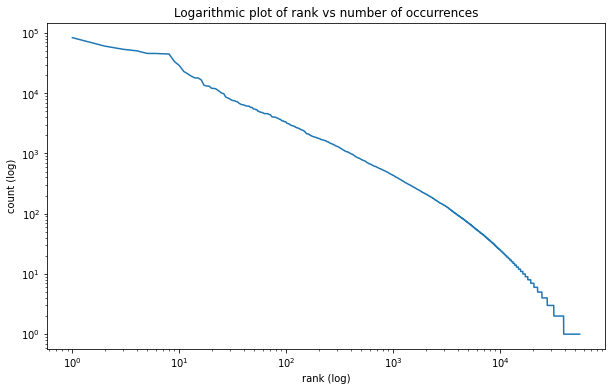

In [11]:
plt.figure(figsize=(10, 6))

ranks = np.arange(1, len(fixed_freq_list) + 1)
sorted_counts = [c[1] for c in word_counts]

plt.loglog(ranks, sorted_counts)

plt.title('Logarithmic plot of rank vs number of occurrences')
plt.xlabel('rank (log)')
plt.ylabel('count (log)')

plt.show()

The shape of the curve is close to a line! That means that the function of the rank vs the number of occurences is exponential.

# Task 8

In [12]:
def is_in_morf(word):
    return morf.analyse(word)[0][2][2] != 'ign' # ign - not in the dict

tokens_not_in_morf = {}
morf_freq_list = {}
for token, count in fixed_freq_list.items():
    if not is_in_morf(token):
        tokens_not_in_morf[token] = count
    else:
        morf_freq_list[token] = count
        
tokens_not_in_morf = Counter(tokens_not_in_morf)
morf_freq_list = Counter(morf_freq_list)
        
len(tokens_not_in_morf), len(morf_freq_list)

(2755, 52389)

# Task 9

In [13]:
list(tokens_not_in_morf.most_common())[:30]

[('poz', 45224),
 ('późn', 1065),
 ('str', 516),
 ('gmo', 298),
 ('sww', 216),
 ('operacyjno', 209),
 ('skw', 196),
 ('rolno', 194),
 ('zm', 192),
 ('ex', 167),
 ('ike', 162),
 ('społeczno', 137),
 ('techniczno', 125),
 ('remediacji', 120),
 ('ure', 103),
 ('rozdz', 102),
 ('uke', 97),
 ('itp', 96),
 ('kn', 95),
 ('sanitarno', 88),
 ('charytatywno', 87),
 ('np', 85),
 ('cn', 83),
 ('pkwiu', 81),
 ('udt', 77),
 ('bswsg', 70),
 ('bswp', 66),
 ('biobójczych', 63),
 ('organizacyjno', 58),
 ('phs', 53)]

# Task 10

In [14]:
tokens_not_in_morf_5_count = [token for token, count in tokens_not_in_morf.items() if count == 5]

random.seed(11301541) # some "random" seed to get the same results every time
random_not_in_morf_5 = random.sample(tokens_not_in_morf_5_count, 30)
random_not_in_morf_5

['winopochodne',
 'eudravigilance',
 'shigella',
 'schetyna',
 'jed',
 'agave',
 'betezda',
 'odgazowywacze',
 'denitracyjne',
 'urt',
 'sposb',
 'cznika',
 'metylofenetyloamina',
 'tzn',
 'chelatującym',
 'informacyjno',
 'kj',
 'rialnego',
 'swine',
 'rr',
 'próbobiorców',
 'szcze',
 'ośc',
 'heptanol',
 'instrumen',
 'gj',
 'inspekcyjno',
 'geodezyjno',
 'siarczano',
 'mieszkalno']

# Task 11
- idea: find the highest token among the ones with the smallest possible Levenshtein distance.
- algorithm: calculate the distances from the top of the frequency list and return the first occurence of the smallest possible Levenshtein distance.

In [15]:
def find_correction(word):
    min_dist = float('inf')
    min_dist_token = ''
    for i, (token, count) in enumerate(morf_freq_list.most_common()):
        if token in morf_freq_list: # only consider words available in the dict
            dist = levenshtein_dist(word, token)
            if dist < min_dist: # with < we take the most frequent one
                min_dist = dist
                min_dist_token = token
            if min_dist == 1:
                break
    return min_dist_token, min_dist

def bold(word):
    return '\033[1m' + word + '\033[0;0m'

display(HTML(f'<h3>My algorithm</h3>'))
start = time.time()
for i, word in enumerate(random_not_in_morf_5):
    corr, dist = find_correction(word)
    print(f'{i + 1:>3}. {bold(word):>30} >>> Most likely correction: {bold(corr):30} (Levenshtein distance: {dist})')
end = time.time()
print(f'{end - start:.2f} seconds elapsed')

  1.         winopochodne >>> Most likely correction: krwiopochodne        (Levenshtein distance: 3)
  2.       eudravigilance >>> Most likely correction: udzielanie           (Levenshtein distance: 7)
  3.             shigella >>> Most likely correction: skreśla              (Levenshtein distance: 4)
  4.             schetyna >>> Most likely correction: schedy               (Levenshtein distance: 3)
  5.                  jed >>> Most likely correction: jej                  (Levenshtein distance: 1)
  6.                agave >>> Most likely correction: agape                (Levenshtein distance: 1)
  7.              betezda >>> Most likely correction: betel                (Levenshtein distance: 3)
  8.        odgazowywacze >>> Most likely correction: odgruzowywanie       (Levenshtein distance: 4)
  9.         denitracyjne >>> Most likely correction: dekoracyjne          (Levenshtein distance: 3)
 10.                  urt >>> Most likely correction: art                  (Levenshtein dis

# Task 12

### Define Index

In [16]:
INDEX_DEFINED = True

In [17]:
index_name = 'lab3_index'

if not INDEX_DEFINED:
    if es.indices.exists(index=index_name):
        es.indices.delete(index=index_name)

    es.indices.create(index=index_name)

In [18]:
sgjp_path = './sgjp-20221023.tab' # source: http://morfeusz.sgjp.pl/download/ (Słownik (SGJP) (dane tekstowe))
header_length = 28

if not INDEX_DEFINED:
    def word_insert_generator():
        with open(sgjp_path, encoding='utf-8') as file:
            for _ in zip(range(header_length), file): pass # skip the header
            for i, line in enumerate(file):
                word = line.split()[0].lower() # load lowercase
                yield {
                    '_index': index_name,
                    'word': word
                }

    start = time.time()
    es_helpers.bulk(es, word_insert_generator(), request_timeout=3600)
    end = time.time()
    print(f'{end - start:.2f} seconds elapsed') # measured around 8 minutes

### Task

In [19]:
def find_es_corrections(word):
    response = es.search(
        index=index_name, 
        query={
            "fuzzy": {
                "word": {
                    "value": word,
                    "fuzziness": '2'
                }
            }
        }
    )
    return [hit['_source']['word'] for hit in response['hits']['hits']], [hit['_score'] for hit in response['hits']['hits']]

In [20]:
display(HTML(f'<h3>Elasticsearch</h3>'))
start = time.time()
for i, word in enumerate(random_not_in_morf_5):
    corrs, scores = find_es_corrections(word)
    if not corrs:
        print(f'{i + 1:>3}. {bold(word):>30} >>> Could not find any correction')
    else:
        print(f'{i + 1:>3}. {bold(word):>30} >>> Most likely correction: {bold(corrs[0]):30} (Score: {scores[0]})')
end = time.time()
print(f'{end - start:.2f} seconds elapsed')

  1.         winopochodne >>> Could not find any correction
  2.       eudravigilance >>> Could not find any correction
  3.             shigella >>> Could not find any correction
  4.             schetyna >>> Most likely correction: chatyna              (Score: 11.015485)
  5.                  jed >>> Most likely correction: bed                  (Score: 9.414449)
  6.                agave >>> Most likely correction: agape                (Score: 11.049079)
  7.              betezda >>> Most likely correction: berenda              (Score: 10.650407)
  8.        odgazowywacze >>> Most likely correction: odgazowywanie        (Score: 12.616635)
  9.         denitracyjne >>> Most likely correction: defibracyjne         (Score: 11.93538)
 10.                  urt >>> Most likely correction: art                  (Score: 8.570204)
 11.                sposb >>> Most likely correction: sposób               (Score: 10.069515)
 12.               cznika >>> Most likely correction: czoika           

# Task 13

In [28]:
for i, word in enumerate(random_not_in_morf_5):
    my_corr, my_dist = find_correction(word)
    
    es_corrs, _ = find_es_corrections(word)
    es_corr = es_corrs[0] if es_corrs else 'correction not found'
    es_dist = '-' if es_corr == 'correction not found' else levenshtein_dist(word, es_corr)
    
    
    print(f'{i + 1:>3}. {bold(word):>30} >>> My algorithm: {bold(my_corr):30} (lev. dist: {my_dist}), Elasticsearch: {bold(es_corr):30} (lev. dist: {es_dist})')

  1.         winopochodne >>> My algorithm: krwiopochodne        (lev. dist: 3), Elasticsearch: correction not found (lev. dist: -)
  2.       eudravigilance >>> My algorithm: udzielanie           (lev. dist: 7), Elasticsearch: correction not found (lev. dist: -)
  3.             shigella >>> My algorithm: skreśla              (lev. dist: 4), Elasticsearch: correction not found (lev. dist: -)
  4.             schetyna >>> My algorithm: schedy               (lev. dist: 3), Elasticsearch: chatyna              (lev. dist: 2)
  5.                  jed >>> My algorithm: jej                  (lev. dist: 1), Elasticsearch: bed                  (lev. dist: 1)
  6.                agave >>> My algorithm: agape                (lev. dist: 1), Elasticsearch: agape                (lev. dist: 1)
  7.              betezda >>> My algorithm: betel                (lev. dist: 3), Elasticsearch: berenda              (lev. dist: 2)
  8.        odgazowywacze >>> My algorithm: odgruzowywanie       (lev. dist:

# Task 14 – conclusions

#### The distribution of words in the corpus
- The shape of the curve from task 7 is close to a line (on a log-log plot). That means that the relation between the rank of a word and the number of its occurences id exponential. 
- Only around ten first words are used more than 10000 times. then, first hundred words are used more than 1000 times, etc.
- There are only few words that ar eused really frequently ('art', 'do', 'się'...).

#### The number of true misspellings vs. the number of unknown words
- The most frequent words not present in Morfeusz are abbreviations ('poz', 'gmo', 'późn') or other unknown words ('charytatywno', 'operacyjno', 'remediacji'). There are no misspellings in the top 30 tokens not present in the dictionary.
- On the other hand, the misspellings can be found in the rare tokens (Task 10). Still, they are the minority, and the most of these tokens are just words in unusual forms ('geodezyjno', etc.)

#### The performance of your method compared to ElasticSearch
- The main disadvantage of the Elasticsearch approach was the time needed to add the words to an index (around 8 minutes). Apart from that, it is much faster. My method needed arond a second to do the task, while the Elasticsearch method needed ~0.7 second, even though Elasticsearch handled much more words (circa 7,000,000 compared to c. 50,000 handled by my method).
- The difference is mainly caused by the inefficiency of my algorithm. Instead of iterating through the whole dictionary, I could try to generate words different by 1 or 2 in terms of the Levenshtein distance and test if they are in the dictionary.

#### The results provided by your method compared to ElasticSearch and the validity of the obtained corrections
- I could not force Elasticsearch to use the 'fuzziness' parameter bigger than 2 (or 'AUTO'), so it doesn't show results for where a bigger fuzziness is required. On the other hand, if the Levenshtein distance is bigger than 2, the correction might not be relevant.
- The main advantage of my model is that it includes the frequency list in the result.
- The results are mostly different, primarily due to the fact that the Elasticsearch used far more words (sometimes it recognised the words not recognised based on the bill dataset used in my approach.
- Apart from the comments above, the results returned by both methods most often make sense. Due to the bigger dataset, the corrections proposed by Elasticsearch usually have smaller values of the Levenshtein distance.